In [1]:
import numpy as np
import matplotlib.pyplot as plt

1\. **Kernel Density Estimate**

Produce a KDE for a given distribution (by hand, not using seaborn!):

* Fill a numpy array, x,  of len(N) (with N=O(100)) with a variable normally distributed, with a given mean a standard deviation
* Fill an histogram in pyplot taking properly care about the aesthetic
   * use a meaningful number of bins
   * set a proper y axis label
   * set proper value of y axis major ticks labels (e.g. you want to display only integer labels)
   * display the histograms as data points with errors (the error being the poisson uncertainty)
* for every element of x, create a gaussian with the mean corresponding the element value and std as a parameter that can be tuned. The std default value should be:
$$ 1.06 * x.std() * x.size ^{-\frac{1}{5.}} $$
you can use the scipy function `stats.norm()` for that.
* In a separate plot (to be placed beside the original histogram), plot all the gaussian functions so obtained
* Sum (with np.sum()) all the gaussian functions and normalize the result such that the integral matches the integral of the original histogram. For that you could use the `scipy.integrate.trapz()` method


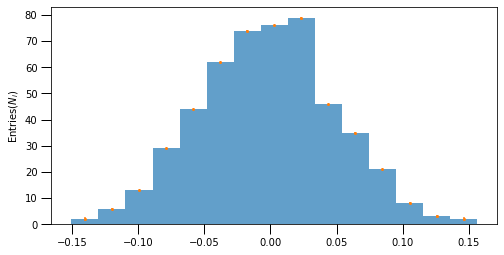

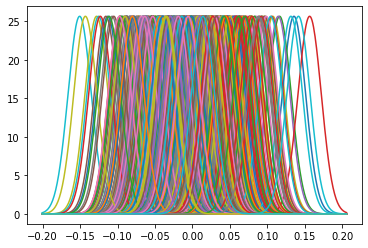

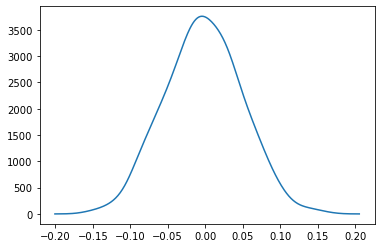

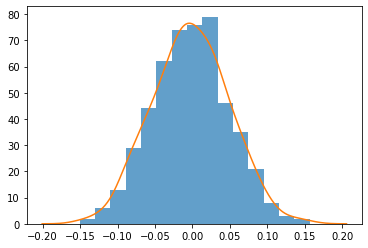

In [2]:
x = np.random.normal(0, 0.05, 500)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))
h = ax.hist(x, bins=15, range=(x.min(), x.max()), label='x', alpha=0.7)
ax.set_ylabel("Entries($N_i$)")
ax.tick_params(which='major', width=1.0)
ax.tick_params(which='major', length=10)
counts,bin_edges, _ = h
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
err = [1/np.sqrt(abs(counts)) for counts in counts]
plt.errorbar(bin_centres, counts, yerr=err, fmt='o', markersize='2')
plt.show()

from scipy.stats import norm
from scipy.integrate import trapz
z = np.arange(x.min()-0.05, x.max()+0.05, 0.001)
std = 1.06*x.std()*np.power(len(x),-1/5)
[plt.plot(z, norm.pdf(z, x[i], scale=std)) for i in range(len(x))]
plt.show()
s = np.sum([norm.pdf(z,x[i],scale = std) for i in range(len(x))],axis=0)
plt.plot(z,s)
plt.show()
norm = trapz(s,z)
normhisto = trapz(counts, bin_centres)
plt.hist(x, bins=15, range=(x.min(), x.max()), label='x', alpha=0.7)
plt.plot(z,s/norm*normhisto)
plt.show()

#very small poisson uncertainty (1/sqrt(N_i)) with respect to the scale of the y-axis: almost invisible error bars)

2\. **Color-coded scatter plot**

Produce a scatter plot out of a dataset with two categories

* Write a function that generate a 2D datasets of 2 categories. Each category should distribute as a 2D gaussian with a given mean and std (clearly it is better to have different values means..)
* Display the dataset in a scatter plot marking the two categories with different marker colors.

An example is given below

You can try to make the procedure more general by allowing a given number $n\ge 2$ of categories

In [3]:
# ! wget https://www.dropbox.com/s/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
# from IPython.display import Image
# Image('two_categories_scatter_plot.png')

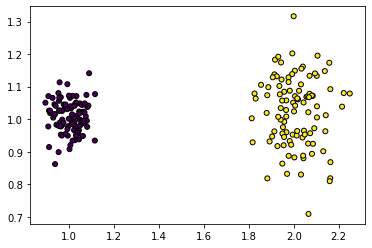

In [4]:
from sklearn.datasets import make_classification
from sklearn.datasets import make_blobs
from sklearn.datasets import make_gaussian_quantiles

def TwoD_Gaus(m11,m12, m21, m22, std1,std2):
    n_samples = [100, 100]
    centers = np.array([[m11, m12], [m21, m22]])
    cluster_stds = np.array([std1, std2])

    X1, Y1 = make_blobs(n_samples=n_samples, n_features=2, centers=centers, cluster_std=cluster_stds)

    plt.scatter(X1[:, 0], X1[:, 1], marker='o', c=Y1,
                s=25, edgecolor='k')
    return

TwoD_Gaus(1,1,2,1,0.05,0.1)

3\. **Profile plot**

Produce a profile plot from a scatter plot.
* Download the following dataset and load it as a pandas dataframe:
```bash
wget https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy
```
Note that you should use the `np.load()` function to load the file as a numpy array, call the `.item()` method, and then pass it to the `pd.DataFrame()` constructor.
* Inspect the dataset, you'll find two variables (features)
* Clean the sample by selecting the entries (rows) with the variable "residual" in absolute value smaller than 2
* perform a linear regression of "residuals" versus "distances" using `scipy.stats.linregress()` 
* plot a seaborn jointplot of  "residuals" versus "distances", having seaborn performing a linear regression. The result of the regression should be displayed on the plot
* Fill 3 numpy arrays
  * x, serving as an array of bin centers for the "distance" variable. It should range from 0 to 20 with reasonable number of steps (bins)
  * y, the mean values of the "residuals", estimated in slices (bins) of "distance"
  * erry, the standard deviation of the  of the "residuals", estimated in slices (bins) of "distance"
* Plot the profile plot on top of the scatter plot

[ 0.          2.22222222  4.44444444  6.66666667  8.88888889 11.11111111
 13.33333333 15.55555556 17.77777778 20.        ] [ 1.11111111  3.33333333  5.55555556  7.77777778 10.         12.22222222
 14.44444444 16.66666667 18.88888889 21.11111111]


<ErrorbarContainer object of 3 artists>

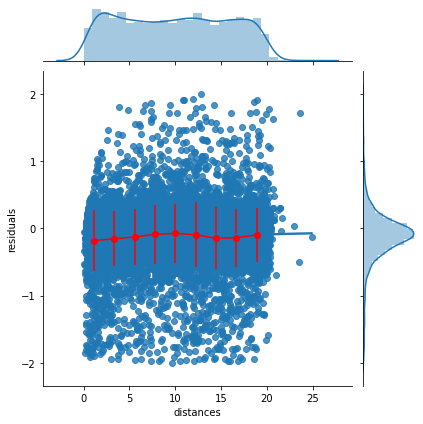

In [5]:
import pandas as pd
import scipy
import seaborn as sns
data = np.load('/Users/michelecrudele/Data/residuals_261.npy',allow_pickle=True)
df = pd.DataFrame(data.item())
df = df[np.abs(df['residuals'])<2]
slope, intercept, rvalue, pvalue, stderr = scipy.stats.linregress(df['distances'], df['residuals'])
jointplot = sns.jointplot(x="distances", y="residuals", data=df, kind= "reg")
x = np.linspace(0, 20, 10)
y = [np.mean(df['residuals'][df['distances']>x[i]][df['distances']<x[i+1]]) for i in range(0,len(x)-1)]
erry = [np.std(df['residuals'][df['distances']>x[i]][df['distances']<x[i+1]]) for i in range(0,len(x)-1)]
x_c = x+(x[1]/2)
print(x,x_c)
plt.errorbar(x_c[:-1], y, yerr = erry, color = 'red', marker = 'o')